<a href="https://colab.research.google.com/github/NIXBLACK11/ModelForAnalysis/blob/main/VideoRating2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! rm -rf sample_data

In [7]:
! rm -rf audio screenshot

To extract audio and images to create train dataset

In [6]:
from moviepy.video.io.VideoFileClip import VideoFileClip
import os
from PIL import Image

audioIndex = 0
imageIndex = 0
totalTime = 0

def extract_screenshots_and_audio(input_video_path, output_screenshots_folder, output_audio_folder):
    global audioIndex, imageIndex, totalTime

    # Create output folders if they don't exist
    os.makedirs(output_screenshots_folder, exist_ok=True)
    os.makedirs(output_audio_folder, exist_ok=True)

    # Load video
    video_clip = VideoFileClip(input_video_path)

    # Extract screenshots and calculate mean time duration
    screenshots = []
    mean_time_duration = 0
    for timestamp in range(0, int(video_clip.duration), 5):
        screenshot = video_clip.get_frame(timestamp)

        # Convert NumPy array to PIL Image
        pil_image = Image.fromarray(screenshot)

        screenshots.append(pil_image)
        mean_time_duration += timestamp

        screenshot_path = os.path.join(output_screenshots_folder, f"screenshot_{imageIndex}.png")
        imageIndex += 1
        pil_image.save(screenshot_path)

    totalTime += video_clip.duration

    # Extract audio
    # audio = video_clip.audio
    # audio_path = os.path.join(output_audio_folder, f"audio_{audioIndex}.wav")
    # audio.write_audiofile(audio_path)

    # audioIndex += 1  # Increment audio index for unique filenames

    # Close video clip
    video_clip.close()

if __name__ == "__main__":
  genres = ['MrBeastType', 'VlogType', 'TechReviewType', 'GamingType', 'MinimalistType']

  for genre in genres:
      input_video_path = "/content/drive/MyDrive/videos/"+genre
      output_screenshots_folder = "/content/screenshot/"+genre
      output_audio_folder = "/content/audio/"+genre

      totalFiles = 0

      for filename in os.listdir(input_video_path):
        # Construct the full file path
        input_video_file = os.path.join(input_video_path, filename)

        # Check if it's a file (not a subdirectory)
        if os.path.isfile(input_video_file):
            # Call the function with the file path
            extract_screenshots_and_audio(input_video_file, output_screenshots_folder, output_audio_folder)
            totalFiles += 1

      averageTime = totalTime / totalFiles
      print(averageTime)


KeyboardInterrupt: 

In [ ]:
genres = ['MrBeastType', 'VlogType', 'TechReviewType', 'GamingType', 'MinimalistType']

import os
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Set the paths
base_dir = '/content/screenshot'

# Create a dictionary to map genres to their respective folders
genre_folders = {
    'MrBeastType': 'MrBeastType',
    'VlogType': 'VlogType',
    'TechReviewType': 'TechReviewType',  # Change 'C' to the actual folder name for TechReviewType
    'GamingType': 'GamingType',  # Change 'D' to the actual folder name for GamingType
    'MinimalistType': 'MinimalistType'  # Change 'E' to the actual folder name for MinimalistType
}

# Get the list of image files for each genre
genre_images = {}
for genre, folder in genre_folders.items():
    genre_dir = os.path.join(base_dir, folder)
    genre_images[genre] = [os.path.join(genre_dir, img) for img in os.listdir(genre_dir)]

# Choose an equal number of images from all classes
num_images_per_genre = min(len(images) for images in genre_images.values())
for genre in genre_images:
    genre_images[genre] = genre_images[genre][:num_images_per_genre]

# Split the data into train and test sets for each genre
train_images, test_images = {}, {}
for genre, images in genre_images.items():
    train_images[genre], test_images[genre] = train_test_split(images, test_size=0.2, random_state=42)

# Create train and test directories for each genre
train_dir = '/content/dataset/train/'
test_dir = '/content/dataset/test/'

for genre in genres:
    os.makedirs(os.path.join(train_dir, genre), exist_ok=True)
    os.makedirs(os.path.join(test_dir, genre), exist_ok=True)

# Copy an equal number of images to train and test directories for each genre
for genre in genres:
    for img in train_images[genre]:
        os.system(f'cp "{img}" "{os.path.join(train_dir, genre)}"')

    for img in test_images[genre]:
        os.system(f'cp "{img}" "{os.path.join(test_dir, genre)}"')

# Set up image data generators for train and test sets
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multiple classes
    classes=genres
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multiple classes
    classes=genres
)


**Train the visual model**

In [ ]:
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pickle

# Function to create, compile, train, and save model with 'adamax' optimizer
def train_and_save_model(train_generator, test_generator):
    # Load the VGG16 model and remove the final layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(genres), activation='softmax')(x)  # Use 'softmax' for multiple classes

    # Create a new model by combining the VGG16 base model and the new layers
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(genres), activation='softmax'))  # Use 'softmax' for multiple classes

    # Freeze the VGG16 base layers and train the new layers
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])  # Use 'categorical_crossentropy' for multiple classes

    print("\nTraining model with optimizer: adamax")

    history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=20,
        validation_data=test_generator,
        validation_steps=test_generator.samples // batch_size
    )

    # Save the model
    model.save('/content/drive/MyDrive/videos/video_analysis_vgg16_adamax.h5')

    # Save the training history to a file
    history_path = '/content/drive/MyDrive/videos/training_history_adamax.pkl'
    with open(history_path, 'wb') as file:
        pickle.dump(history.history, file)

    return history

# Set up image data generators for train and test sets
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multiple classes
    classes=genres
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multiple classes
    classes=genres
)

# Train and save model with 'adamax' optimizer
history = train_and_save_model(train_generator, test_generator)

# Access training metrics for plotting
print(f'Model with optimizer adamax - Final Training Accuracy: {history.history["accuracy"][-1]}, Final Validation Accuracy: {history.history["val_accuracy"][-1]}')


**Visualize the training**

In [ ]:
from tensorflow.keras.models import load_model

# Evaluate the model with 'adamax' optimizer
optimizer_name = 'adamax'
model_path = f'/content/drive/MyDrive/videos/video_analysis_vgg16_{optimizer_name}.h5'
model = load_model(model_path)

# Evaluate the model on the "test" set
test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_generator.samples // batch_size)

print(f'Model with optimizer {optimizer_name} - Test accuracy: {test_acc}, Test loss: {test_loss}')


In [ ]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle('Training and Validation Metrics')

# Evaluate the model with 'adamax' optimizer
optimizer_name = 'adamax'
model_path = f'/content/drive/MyDrive/videos/video_analysis_vgg16_{optimizer_name}.h5'
model = load_model(model_path)

# Load training history
history_path = f'/content/drive/MyDrive/videos/training_history_{optimizer_name}.pkl'  # Replace with the actual path
with open(history_path, 'rb') as file:
    history = pickle.load(file)

# Plot accuracy
ax1.plot(history['accuracy'], label=f'{optimizer_name} Training Accuracy')
ax1.plot(history['val_accuracy'], label=f'{optimizer_name} Validation Accuracy')

# Plot loss
ax2.plot(history['loss'], label=f'{optimizer_name} Training Loss')
ax2.plot(history['val_loss'], label=f'{optimizer_name} Validation Loss')

# Set labels and title
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.show()


**Audio part**

In [ ]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D

# Function to extract MFCC features from audio files
def extract_features(file_path):
    y, sr = librosa.load(file_path, mono=True, duration=5)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return mfccs

# List of genres
genres = ['MrBeastType', 'VlogType', 'TechReviewType', 'GamingType', 'MinimalistType']

# List to store features and labels
features = []
labels = []

# Load data for each genre
for i, genre in enumerate(genres):
    genre_path = f'/content/audio/{genre}'
    for file_name in os.listdir(genre_path):
        file_path = os.path.join(genre_path, file_name)
        mfccs = extract_features(file_path)
        features.append(mfccs)
        labels.append(i)  # Assign a unique label for each genre

# Convert lists to NumPy arrays
X = np.array(features)
y = np.array(labels)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Transpose the MFCCs before reshaping
X_train = X_train.transpose(0, 2, 1)
X_val = X_val.transpose(0, 2, 1)
X_test = X_test.transpose(0, 2, 1)

# Reshape the input data to match Conv1D input shape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Define and compile the model
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(len(genres), activation='softmax'))  # Output layer with softmax activation for multiple genres
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Save the trained model
model.save('/content/drive/MyDrive/videos/audio_analysis_multi_genre.h5')


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 112.5824 - accuracy: 0.1905 - val_loss: 255.7360 - val_accuracy: 0.0000e+00
Epoch 2/40
1/1 [==============================] - 0s 115ms/step - loss: 176.3468 - accuracy: 0.2381 - val_loss: 163.8461 - val_accuracy: 0.4000
Epoch 3/40
1/1 [==============================] - 0s 116ms/step - loss: 97.1571 - accuracy: 0.3810 - val_loss: 170.7296 - val_accuracy: 0.2000
Epoch 4/40
1/1 [==============================] - 0s 111ms/step - loss: 118.8634 - accuracy: 0.3333 - val_loss: 172.2961 - val_accuracy: 0.2000
Epoch 5/40
1/1 [==============================] - 0s 136ms/step - loss: 117.0775 - accuracy: 0.2857 - val_loss: 120.8457 - val_accuracy: 0.2000
Epoch 6/40
1/1 [==============================] - 0s 111ms/step - loss: 62.4390 - accuracy: 0.4762 - val_loss: 85.7447 - val_accuracy: 0.4000
Epoch 7/40
1/1 [==============================] - 0s 104ms/step - loss: 49.5577 - accuracy: 0.6667 - val_loss: 75.7190 - val_accuracy: 0.6

To predict a random video from the dataset

In [8]:
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import load_model

# Function to preprocess an image for prediction
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the pixel values to be between 0 and 1
    return img_array, img

# Choose a random image from the test folder
test_images_folder = '/content/dataset/test'
genres = ['MrBeastType', 'VlogType', 'TechReviewType', 'GamingType', 'MinimalistType']
random_genre = random.choice(genres)
random_image_name = random.choice(os.listdir(os.path.join(test_images_folder, random_genre)))
random_image_path = os.path.join(test_images_folder, random_genre, random_image_name)

# Preprocess the image
img, original_img = preprocess_image(random_image_path)

# Load the 'adamax' model
optimizer_name = 'adamax'
model_path = f'/content/drive/MyDrive/videos/video_analysis_vgg16_{optimizer_name}.h5'
model = load_model(model_path)

# Make a prediction
prediction = model.predict(img)

# Display the result along with the actual image and selected genre
plt.imshow(original_img)
plt.axis('off')

print(f'Model with optimizer {optimizer_name}:')
print(f'Selected from genre: {random_genre}')
predicted_genre = genres[np.argmax(prediction)]
plt.title(f'Predicted: {predicted_genre}')
plt.show()
print('---')


FileNotFoundError: [Errno 2] No such file or directory: '/content/dataset/test/MinimalistType'

# To predict a new video


In [32]:
! rm -rf Test

Extract audio and video from the video to predict

In [33]:
from moviepy.video.io.VideoFileClip import VideoFileClip
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os
from PIL import Image

audioIndex = 0
imageIndex = 0
totalTime = 0

# Load the 'adamax' model
optimizer_name = 'adamax'
model_path = '/content/drive/MyDrive/videos/video_analysis_vgg16_adamax.h5'
model = load_model(model_path)

# Define the target size expected by the model
target_size = (224, 224)

def preprocess_image(img):
    # Resize the image to the target size
    img = img.resize(target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the pixel values to be between 0 and 1
    return img_array

def extract_screenshots_and_audio(input_video_path, output_screenshots_folder, output_audio_folder):
    global audioIndex, imageIndex, totalTime

    # Create output folders if they don't exist
    os.makedirs(output_screenshots_folder, exist_ok=True)
    os.makedirs(output_audio_folder, exist_ok=True)

    # Load video
    video_clip = VideoFileClip(input_video_path)

    # Extract screenshots and calculate mean time duration
    screenshots = []
    mean_time_duration = 0
    for timestamp in range(0, int(video_clip.duration), 2):
        screenshot = video_clip.get_frame(timestamp)

        # Convert NumPy array to PIL Image
        pil_image = Image.fromarray(screenshot)

        # Save screenshot
        screenshot_path = os.path.join(output_screenshots_folder, f"{imageIndex}.png")
        imageIndex += 1
        pil_image.save(screenshot_path)

        screenshots.append(pil_image)
        mean_time_duration += timestamp

    totalTime += video_clip.duration

    # # Extract audio in 30-second chunks
    # audio = video_clip.audio
    # chunk_duration = 2  # seconds

    # for start_time in range(0, int(video_clip.duration), chunk_duration):
    #     end_time = min(start_time + chunk_duration, int(video_clip.duration))
    #     audio_chunk = audio.subclip(start_time, end_time)
    #     audio_chunk_path = os.path.join(output_audio_folder, f"audio_{audioIndex}_{start_time}-{end_time}.wav")
    #     audio_chunk.write_audiofile(audio_chunk_path, codec='pcm_s16le', ffmpeg_params=["-ac", "1"])
    #     audioIndex += 1

    # Close video clip
    video_clip.close()

if __name__ == "__main__":
    input_video_path = "/content/drive/MyDrive/videos/TestVideos/GamingType.mp4"
    output_screenshots_folder = "/content/Test/screenshot"
    output_audio_folder = "/content/Test/audio"

    genres = ['MrBeastType', 'VlogType', 'TechReviewType', 'GamingType', 'MinimalistType']

    # Call the function with the video file path
    extract_screenshots_and_audio(input_video_path, output_screenshots_folder, output_audio_folder)

    # Calculate average time (if needed)
    averageTime = totalTime
    print(averageTime)


1698.28


**Visual prediction**

1/1 [==============================] - 0s 34ms/step


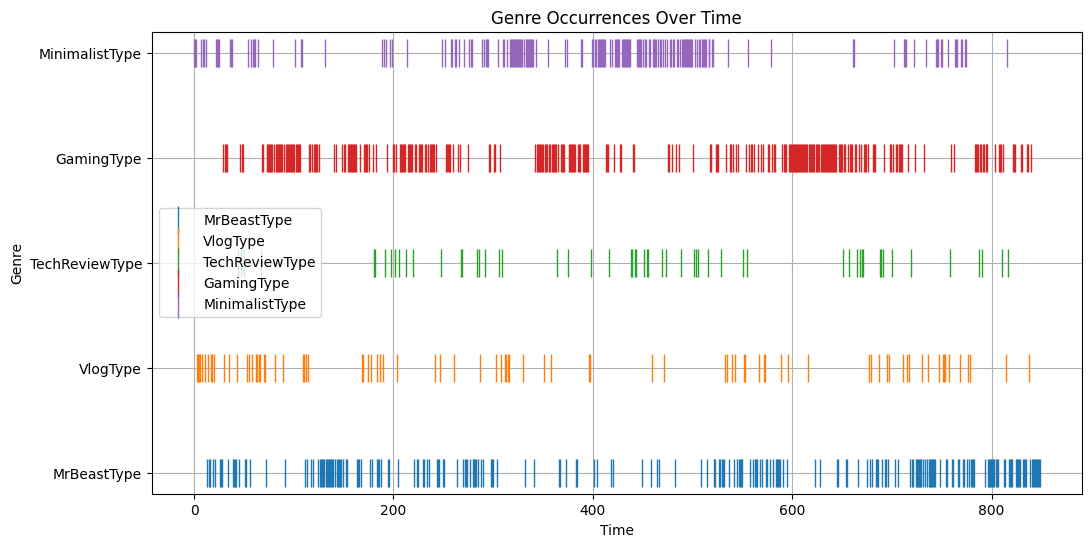

In [42]:
import os
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
import matplotlib.pyplot as plt

# Define the optimizer name
optimizer_name = 'adamax'

# Load the model
model_path = f'/content/drive/MyDrive/videos/video_analysis_vgg16_{optimizer_name}.h5'
model = load_model(model_path)

# Define genre list
genres = ['MrBeastType', 'VlogType', 'TechReviewType', 'GamingType', 'MinimalistType']

# Function to preprocess an image for prediction
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the pixel values to be between 0 and 1
    return img_array

# Function to predict the genre using the loaded model
def predict_genre(img):
    # Make a prediction
    prediction = model.predict(img)
    # Get the genre with the highest probability
    predicted_genre = genres[np.argmax(prediction)]
    return predicted_genre

# Define genre folders
genre_folders = {
    'MrBeastType': 'MrBeastType',
    'VlogType': 'VlogType',
    'TechReviewType': 'TechReviewType',
    'GamingType': 'GamingType',
    'MinimalistType': 'MinimalistType'
}

# Initialize a dictionary to store genre occurrences over time
genre_occurrences = {genre: [] for genre in genres}

# Loop through all screenshots
for image_name in os.listdir("/content/Test/screenshot"):
    # Preprocess the image
    image_path = os.path.join("/content/Test/screenshot", image_name)
    img = preprocess_image(image_path)

    # Predict the genre using the loaded model
    predicted_genre = predict_genre(img)

    # Get the timestamp (assuming the image name format is 'genre_timestamp.png')
    timestamp = int(image_name.split('_')[-1].split('.')[0])

    # Add the timestamp to the list of occurrences for the predicted genre
    genre_occurrences[predicted_genre].append(timestamp)

# Plotting genre occurrences over time
plt.figure(figsize=(12, 6))
for genre, occurrences in genre_occurrences.items():
    plt.plot(occurrences, [genres.index(genre)] * len(occurrences), label=genre, marker='|', linestyle='', markersize=20)

plt.xlabel('Time')
plt.ylabel('Genre')
plt.yticks(range(len(genres)), genres)
plt.title('Genre Occurrences Over Time')
plt.legend()
plt.grid(True)
plt.show()


**To mark boxes of different objects in the image**


1. To install opencv

In [14]:
! pip install opencv-python

2. To install YOLO data

In [15]:
# Download YOLOv3 weights
! wget https://pjreddie.com/media/files/yolov3.weights

# Download YOLOv3 configuration file
! wget https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg

# Download COCO class names file
! wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names


--2024-03-19 12:16:59--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  18.6MB/s    in 12s     

2024-03-19 12:20:26 (20.5 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2024-03-19 12:20:26--  https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg [following]
--2024-03-19 12:20:27--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.c

3. Perform object marking in image

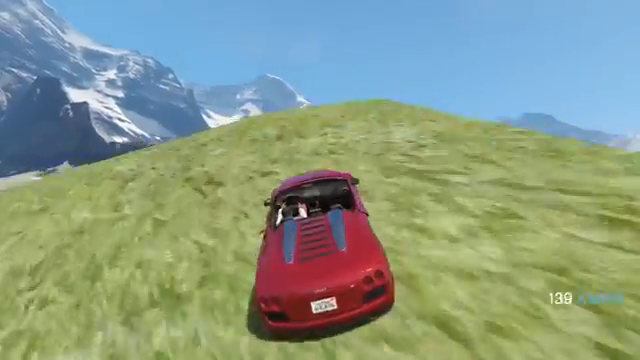

In [37]:
import cv2
from google.colab.patches import cv2_imshow

# Load YOLO
net = cv2.dnn.readNet("/content/yolov3.weights", "/content/yolov3.cfg")
classes = []
with open("/content/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()

# Convert numpy array to a list
unconnected_out_layers = net.getUnconnectedOutLayers().flatten().tolist()

# Create output layers
output_layers = [layer_names[i - 1] for i in unconnected_out_layers]

# Load image
img = cv2.imread("/content/Test/screenshot/807.png")
height, width, channels = img.shape

# Detecting objects
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

# Showing informations on the screen
class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
font = cv2.FONT_HERSHEY_PLAIN
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color = (255, 0, 0)
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, label, (x, y + 30), font, 2, color, 2)

cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()


**Audio pridiction**

In [ ]:
import os
import librosa
import numpy as np
from keras.models import load_model

# Function to extract MFCC features from audio files
def extract_features(file_path):
    y, sr = librosa.load(file_path, mono=True, duration=5)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return mfccs

# Load the trained model
model_path = '/content/drive/MyDrive/videos/audio_analysis_multi_genre.h5'  # Use the model trained for multiple genres
model = load_model(model_path)

# Audio folder path
audio_folder = '/content/Test/audio'

# Initialize counters for each genre
genre_counts = {genre: 0 for genre in genres}

# Loop through all audio files in the folder
for audio_file in os.listdir(audio_folder):
    # Construct the full path for each audio file
    audio_path = os.path.join(audio_folder, audio_file)

    # Extract features from the audio file
    audio_features = extract_features(audio_path)

    # Ensure the features have the expected shape (216 time steps)
    expected_shape = (216, 13)
    if audio_features.shape[1] < expected_shape[0]:
        # Pad the features if they have fewer time steps
        audio_features = np.pad(audio_features, ((0, 0), (0, expected_shape[0] - audio_features.shape[1])))
    elif audio_features.shape[1] > expected_shape[0]:
        # Truncate the features if they have more time steps
        audio_features = audio_features[:, :expected_shape[0]]

    # Transpose and reshape the features
    audio_features = audio_features.transpose(1, 0)  # Transpose
    audio_features = audio_features.reshape(1, audio_features.shape[0], audio_features.shape[1])

    # Predict the class
    prediction = model.predict(audio_features)

    # Map the predicted class to a label
    predicted_class = genres[np.argmax(prediction)]

    # Update counters for each genre
    genre_counts[predicted_class] += 1

# Determine the overall predicted genre based on majority vote
overall_genre = max(genre_counts, key=genre_counts.get)

# Print the prediction for each part and the overall predicted genre
print("Predictions for Each Part:")
for genre, count in genre_counts.items():
    print(f"{genre}: {count} parts")

print(f"\nOverall Predicted Genre: {overall_genre}")


1/1 [==============================] - 0s 25ms/step
Predictions for Each Part:
MrBeastType: 187 parts
VlogType: 0 parts
TechReviewType: 0 parts
GamingType: 211 parts
MinimalistType: 451 parts

Overall Predicted Genre: MinimalistType
